# 1.BUSINESS UNDERSTANDING
    A. INTRODUCTION
In today's digital era, the world of cinema has witnessed a transformative shift. Streaming platforms have unlocked a vast library of movies, granting users unprecedented access to a multitude of entertainment options. However, amidst this abundance, users often find themselves overwhelmed, struggling to identify movies that resonate with their individual tastes. In response to this challenge, I introduce an innovative movie recommendation system, poised to revolutionize the way users discover and enjoy films.

    B.PROBLEM STATEMENT
The proliferation of online streaming platforms has created an ocean of cinematic choices, leaving users adrift in the quest for their next movie night selection. Navigating this vast sea of options can be daunting and time-consuming, often resulting in decision fatigue and missed opportunities to explore content aligned with one's preferences. My project seeks to address this issue by crafting a sophisticated movie recommendation system capable of leveraging user data and machine learning to deliver personalized movie suggestions. It aims to tackle the challenge of guiding users toward enjoyable movie choices, even for those who are new to the platform or movies with limited ratings.

    C.MAIN OBJECTIVE
To create a movie recommendation system that suggests the top 5 movies to users based on their ratings of other movies.

    D.SPECIFIC OBJECTIVES

# 2.IMPORTING LIBRARIES

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 3.LOADING THE DATA

In [15]:
#loading data on movies.csv
movie_data = pd.read_csv('Datasets/movies.csv')
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
#loading data on ratings.csv
rating_data = pd.read_csv('Datasets/ratings.csv')
rating_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# 4.DATA CLEANING


In [17]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [18]:
rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


From the above, the datasets do not contain any missing values.

### 4.1. DROPPING COLUMNS

Only a few features and rows from the various datasets that were gathered are important to the procedure. As a result, in this stage, the features from each dataset that were not necessary were removed. 

In [19]:
rating_data = rating_data.drop(columns=['timestamp'])
rating_data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### 4.2. ENCODING (ONE-HOT ENCODING)

In [20]:
# Convert genres into binary columns
genres = movie_data['genres'].str.get_dummies('|')

# Concatenate the binary genre columns to the movie_data DataFrame
movie_data = pd.concat([movie_data, genres], axis=1)

# Drop the original 'genres' column
movie_data = movie_data.drop(columns=['genres'])
movie_data.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# 5.EXPLORATORY DATA ANALYSIS
###     5.1.MERGE THE DATASETS

In [21]:
# Merge the ratings dataset with the movies dataset based on 'movieId'
merged_data = pd.merge(rating_data, movie_data, on='movieId')
merged_data

,userId,movieId,rating,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100832,610,160527,4.5,Sympathy for the Underdog (1971),0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100833,610,160836,3.0,Hazard (2005),0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100834,610,163937,3.5,Blair Witch (2016),0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


###     5.2.CREATE USER-ITEM RATING MATRIX
After merging,  I created the user-item rating matrix. This matrix will have users as rows, movies as columns, and user ratings as values.The resulting user_item_matrix will be the basis for collaborative filtering, enabling me to make recommendations based on user-item interactions.

In [22]:
user_item_matrix = merged_data.pivot_table(index='userId', columns='movieId', values='rating')
print(user_item_matrix)


movieId  1       2       3       4       5       6       7       8        
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN  \
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...         ...     ...     ...     ...     ...     ...     ...     ...   
606         2.5     NaN     NaN     NaN     NaN     NaN     2.5     NaN   
607         4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
608         2.5     2.0     2.0     NaN     NaN     NaN     NaN     NaN   
609         3.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
610         5.0     NaN     NaN     NaN     NaN     5.0     NaN     NaN   

movieId  9       10     

In [23]:
#handle missing values 
user_item_matrix = user_item_matrix.fillna(0)
print(user_item_matrix)

movieId  1       2       3       4       5       6       7       8        
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0  \
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
606         2.5     0.0     0.0     0.0     0.0     0.0     2.5     0.0   
607         4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
608         2.5     2.0     2.0     0.0     0.0     0.0     0.0     0.0   
609         3.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
610         5.0     0.0     0.0     0.0     0.0     5.0     0.0     0.0   

movieId  9       10     

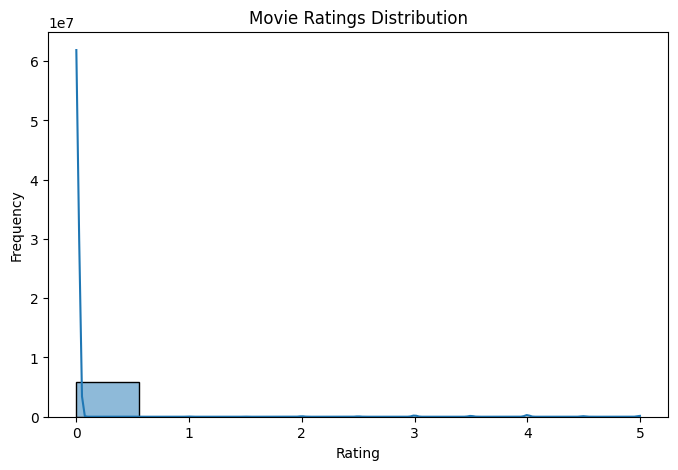

In [24]:
#import matplotlib.pyplot as plt
#import seaborn as sns

# Movie Ratings Distribution
plt.figure(figsize=(8, 5))
sns.histplot(user_item_matrix.stack(), bins=9, kde=True)
plt.title("Movie Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()



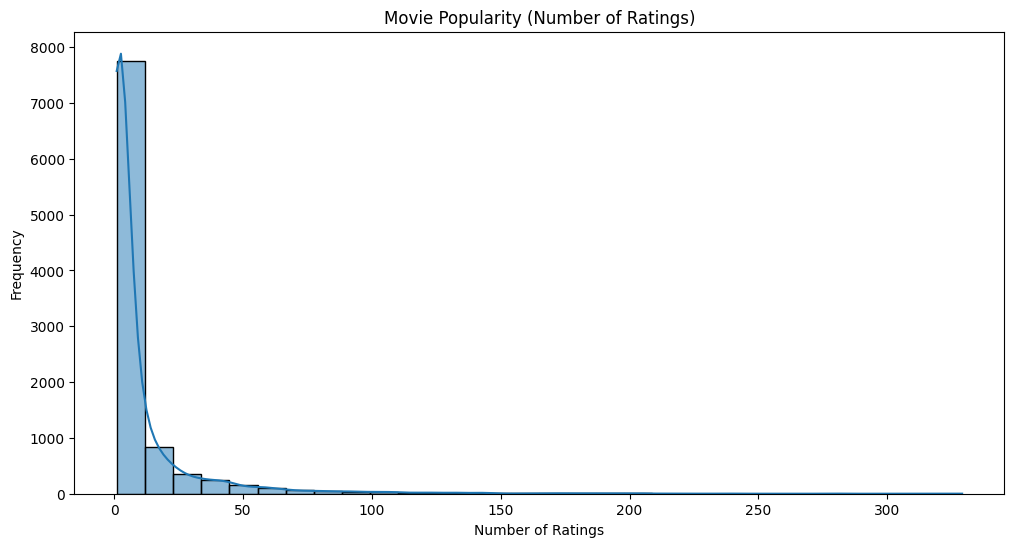

In [25]:
#Movie Popularity (Number of Ratings)
movie_ratings_count = user_item_matrix[user_item_matrix > 0].count()
plt.figure(figsize=(12, 6))
sns.histplot(movie_ratings_count, bins=30, kde=True)
plt.title("Movie Popularity (Number of Ratings)")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

# 6.FEATURE ENGINEERING